# CASADI Opti stack rewrite 
Fix all the god damn bugs

Assume we have a discrete-time model:
$$x_{t+1} = f(x_t, u_t)$$
Denote a whole MPC trajectory, with states $x_0,x_1,\dots,x_N$ and controls $u_1,\dots,u_N$ as $\mathbf{x}$ and $\mathbf{u}$.

We have positional constraints:
$$Ax \leq b$$

We have some interval constraints:
$$x_{min} \leq x_t \leq x_{max},\ i=0,\dots,N$$
$$u_{min} \leq u_t \leq u_{max},\ i=1,\dots,N$$

We have multiobjective weighted cost function which is probably quadratic.
    $$J(\mathbf{x}, \mathbf{u})$$

The nonlinear model is:
\begin{gather*}
\begin{bmatrix}
\dot x\\ \dot y\\ \dot v\\ \dot\psi
%\\ \dot\beta
\end{bmatrix} =
\begin{bmatrix}
v\cos(\psi + \beta)
\\
v\sin(\psi + \beta)
\\
a
\\
\frac{v}{l_r}\sin(\beta)
%\\
%\frac{v}{l_f + l_r}\tan(\delta_f) - \frac{v}{l_r}\sin(\beta)
\end{bmatrix}, \quad \beta = \tan^{-1}\Big(\frac{l_r}{l_r + l_f}\tan(\delta_f)\Big)
\end{gather*}


Assume zero-order-hold on the controls. and $t$, $t+1$ are separated by time $\Delta t$. A very easy discretization is $x_{t+1} = x_t + \dot x_t \Delta t$

In [1]:
# Library dependencies
import casadi            as ca
import numpy             as np
import matplotlib.pyplot as plt
import matplotlib        as mpl

# Local dependencies
from roadrunner_2        import Roadrunner, Segment, OutOfRoadPointsException

N = 30
step=0.075

# system size
n = 4
m = 2

# the 2 vehicle parameters!
lr = 2.10
lf = 2.67

In [2]:
from road                import iso_double_lane_change as test_road
test_road_width = 5.0*np.ones(np.size(test_road)//2)
DESIRED_SPEED = 10.0
n_test_road_pts,_ = np.shape(test_road)

roadrunner = Roadrunner(road_center = test_road, # Road centerline points
                        road_width  = test_road_width,
                        P           = np.size(test_road_width)-1,
                       start_pct = 0.0, end_pct = 1.0) # Number of points to try curve-fitting at a time
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

def desired_speed(k:int):
    return DESIRED_SPEED

xy = np.reshape(roadrunner.evaluate(),(2,))
ic = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]

 [0.   ]] is [5.15721918] away at s = 0.012812955224833677, B(s) = [[3.85965835e+00]
 [2.08495742e-17]]
 [0.   ]] is [4.81310684] away at s = 0.02779445763972867, B(s) = [[7.88027813e+00]
 [5.21094594e-12]]
 [ 0.   ]] is [3.98506649] away at s = 0.04137551854057995, B(s) = [[1.08773931e+01]
 [2.29930668e-09]]
 [ 0.   ]] is [3.23866542] away at s = 0.05931273771466658, B(s) = [[1.38697052e+01]
 [4.27305222e-07]]
 [ 0.   ]] is [3.19963878] away at s = 0.07554884933851191, B(s) = [[1.58691094e+01]
 [1.15450413e-05]]
 [ 0.   ]] is [3.52184003] away at s = 0.0850098371654534, B(s) = [[1.68795387e+01]
 [5.32588756e-05]]
 [ 0.   ]] is [3.71061801] away at s = 0.08977761632331768, B(s) = [[1.73778465e+01]
 [1.05891157e-04]]
 [ 0.   ]] is [3.87718258] away at s = 0.09434930679858958, B(s) = [[1.78600116e+01]
 [1.95631445e-04]]
 [ 0.   ]] is [4.24109201] away at s = 0.10369423821442998, B(s) = [[1.88868908e+01]
 [6.08288387e-04]]
 [ 0.   ]] is [4.39857738] away at s = 0.10664870695083563, B(s) =

 [2.72278490e-14]]
 [  0.]] is [4.20365576] away at s = 0.9605506986460933, B(s) = [[1.66000526e+02]
 [2.28277170e-17]]
 [  0.]] is [4.1986179] away at s = 0.9730440394008157, B(s) = [[1.70006098e+02]
 [3.01346679e-21]]
 [  0.]] is [3.10808332] away at s = 0.9871054871346395, B(s) = [[1.75013700e+02]
 [5.71075795e-29]]
 [  0.]] is [5.] away at s = 1.0, B(s) = [[180.]
 [  0.]]


In [3]:
# Example
'''opti = casadi.Opti()

x = opti.variable()
y = opti.variable()

opti.minimize(  (y-x**2)**2   )
opti.subject_to( x**2+y**2==1 )
opti.subject_to(       x+y>=1 )

opti.solver('ipopt')


sol = opti.solve()

print(sol.value(x))
print(sol.value(y))
'''

"opti = casadi.Opti()\n\nx = opti.variable()\ny = opti.variable()\n\nopti.minimize(  (y-x**2)**2   )\nopti.subject_to( x**2+y**2==1 )\nopti.subject_to(       x+y>=1 )\n\nopti.solver('ipopt')\n\n\nsol = opti.solve()\n\nprint(sol.value(x))\nprint(sol.value(y))\n"

In [4]:
def run_mpc_iteration(z0, coeffs):
    # z0: initial state
    # coeffs: cost weights
    opti = ca.Opti()
    z_prev = z0
    u_prev = np.zeros(m)
    z = opti.variable(n*N)
    u = opti.variable(m*N)
    
    z_guess = np.zeros(n*N)
    u_guess = np.zeros(m*N)

    jerk_cost = 0.0
    steering_change_cost = 0.0
    attractive_cost = 0.0

    for i in range(N):
        z_i = z[i*n:(i+1)*n]
        u_i = u[i*m:(i+1)*m]
        x_i, y_i, v_i, psi_i = z_i[0], z_i[1], z_i[2], z_i[3]
        a_i, delta_f_i = u_i[0], u_i[1]
        beta = ca.arctan(lr/(lr+lf)*ca.tan(delta_f_i))

        zdot = ca.vertcat(
            v_i*ca.cos(psi_i + beta),
            v_i*ca.sin(psi_i + beta),
            a_i,
            v_i/lr*ca.sin(beta),
        )

        jerk_cost += (u_i[0]-u_prev[0])**2
        steering_change_cost += (u_i[1]-u_prev[1])**2
        v_des = desired_speed(i+1)
        xy,psi,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        _,psi_prev,_ = roadrunner.evaluate((i+1)*step*v_des, full_data=True)
        z_guess[i*n:(i+1)*n] = np.array([xy[0,0], xy[0,1],v_des, psi])
        u_guess[i*m:(i+1)*m] = [(v_des-desired_speed(i))/step, (psi - psi_prev)/step]
        attractive_cost += \
            (v_i-desired_speed(i))**2 + (psi_i-psi)**2 +\
            (x_i-xy[0,0])**2 + (y_i-xy[0,1])**2
        
        # Add the polygon bounds at step k                
        bounds, p = roadrunner.bound_x(step,i,desired_speed)

        for (ub, a, b, c, lb) in bounds:
            if a != 0:
                opti.subject_to(opti.bounded(lb,x_i*a + y_i*b + c,ub))
            else:
                opti.subject_to(opti.bounded(lb,y_i*b + c,ub))


        opti.subject_to(z_prev + step*zdot == z_i)
        z_prev = z_i

    opti.set_initial(z, z_guess)
    opti.minimize(jerk_cost*coeffs[0] + steering_change_cost*coeffs[1] + attractive_cost*coeffs[2])
    opti.solver('ipopt')

    sol = opti.solve()
    z = sol.value(z)
    u = sol.value(u)
    z = np.reshape(z,(np.size(z)//n,n))
    u = np.reshape(u,(np.size(u)//m,m))
    return z,u

In [5]:
roadrunner.reset()
# start a bit ahead of the first point to have space for looking back on the road
roadrunner.advance(step*20*DESIRED_SPEED)

xy = np.reshape(roadrunner.evaluate(),(2,))
z0 = [xy[0], xy[1], DESIRED_SPEED, float(roadrunner.get_angle())]

runs = 100
z_history = np.zeros((runs,n))
u_history = np.zeros((runs,m))

for i in range(runs):
    z,u = run_mpc_iteration(z0, np.array([100.0, 10.0*180.0/np.pi, 1.0]))
    
    # stuff that doesn't have to do with control
    dist = np.linalg.norm(z[0,0:2] - z0[0:2],2)
    roadrunner.advance(dist)
    
    # save data
    z0 = z[0,:]
    z_history[i,:] = z[0,:]
    u_history[i,:] = u[0,:]
    



******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equa

/home/esoroka/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:36: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



                                   (scaled)                 (unscaled)
Objective...............:   2.1647081732025458e+02    2.1647081732025458e+02
Dual infeasibility......:   3.5527136788005009e-14    3.5527136788005009e-14
Constraint violation....:   1.7763568394002505e-15    1.7763568394002505e-15
Complementarity.........:   2.5060312055255725e-09    2.5060312055255725e-09
Overall NLP error.......:   2.5060312055255725e-09    2.5060312055255725e-09


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 12
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 12
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPOPT (w/o function evaluations)   =      0.014
Total CPU secs in NLP function evaluations           =      0.005

EX

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      506
Number of nonzeros in inequality constraint Jacobian.:      240
Number of nonzeros in Lagrangian Hessian.............:      270

Total number of variables............................:      180
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      120
Total number of inequality constraints...............:      120
        inequality constraints with only lower bounds:       60
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       60

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

NameError: name 'z_history1' is not defined

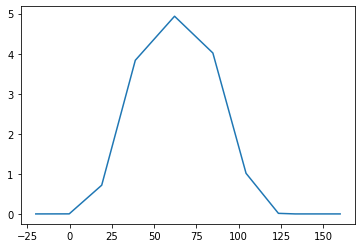

In [6]:
p = roadrunner.plot()

p.plot(z_history1[:,0], z_history1[:,1], label="10.0")
p.plot(z_history[:,0], z_history[:,1], label="0.1")
p.legend()
plt.show()

In [ ]:
plt.plot(u_history[:,0], label="a")
plt.legend()
plt.show()

In [ ]:
plt.plot(u_history[:,1]*180.0/np.pi, label="Steering")
plt.legend()
plt.show()